In [1]:
# Modules de base
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Module relatif à Gurobi
from gurobipy import *

In [2]:
# -- Initialisation du modèle --
# m : Model
m=Model("assign_SR")

Restricted license - for non-production use only - expires 2023-10-25


In [3]:
data_dist = pd.read_csv("distances.csv")
Dij = np.array(data_dist)
Dij.shape

(22, 22)

In [4]:
index_val = pd.read_csv("index_values.csv")
Wi = np.array(index_val)
Wi.shape
#index values as float and not as numpy array
wi = index_val['index_values'].values.tolist()


In [5]:
curr_struct = pd.read_csv("current_structes.csv")
curr_struct = np.array(curr_struct)
print(curr_struct.shape)

(22, 4)


In [6]:
pref1 = pd.read_csv("preferences1.csv")
pref1 = np.array(pref1)
print(pref1.shape)
pref2 = pd.read_csv("preferences2.csv")
pref2 = np.array(pref2)
pref3 = pd.read_csv("preferences3.csv")
pref3 = np.array(pref3)

(22, 4)


In [7]:
V = m.addMVar(shape = (22,4), name = "V", vtype=GRB.BINARY)
print(V)

<(22, 4) matrix variable>


In [8]:
for i in range(V.shape[1]):
    m.addConstr(np.sum(np.transpose(Wi) @ V[:,i]) >= 0.8) # can be modified to 0.7,0.8,0.9,1
for i in range(V.shape[1]):
    m.addConstr(np.sum(np.transpose(Wi) @ V[:,i]) <= 1.2)# can be modified to 1,1.1,1.2,1.3
for i in range(V.shape[0]):
    m.addConstr(quicksum(V[i])==1)


In [9]:
# minimize distances
obj_distance = np.sum(V[:,0] @ Dij[3,:])+\
                np.sum(V[:,1] @ Dij[13,:])+\
                np.sum(V[:,2] @ Dij[15,:])+\
                np.sum(V[:,3] @ Dij[21,:])

m.setObjective(obj_distance, GRB.MINIMIZE)

m.params.outputflag = 0
m.update()

# -- Résolution --
m.optimize()


# -- Vérification du statut et Affichage (le cas échéant) des solutions --
if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tN'A PAS DE SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tEST NON BORNÉ!!!")
else:
  
    Vij = pd.DataFrame(data = V.x, index = range(22), columns = ['SR1','SR2','SR3','SR4'])
    result_workload = V.x*Wi
    # print(result_workload)
    for i in range(4):
        print("the workload of SR", i , " is: ", np.sum(result_workload[:,i]))     
    print("the Vij matrix is: \n",Vij)
    dist = np.sum(V.x[:,0] * Dij[3,:])+\
            np.sum(V.x[:,1] * Dij[13,:])+\
            np.sum(V.x[:,2] * Dij[15,:])+\
            np.sum(V.x[:,3] * Dij[21,:])
    print("the minimum total distance is: ",dist)


the workload of SR 0  is:  1.0375999999999999
the workload of SR 1  is:  1.0447
the workload of SR 2  is:  1.1148999999999998
the workload of SR 3  is:  0.8028000000000001
the Vij matrix is: 
     SR1  SR2  SR3  SR4
0  -0.0 -0.0 -0.0  1.0
1  -0.0 -0.0 -0.0  1.0
2  -0.0 -0.0 -0.0  1.0
3   1.0 -0.0 -0.0 -0.0
4   1.0 -0.0 -0.0 -0.0
5   1.0 -0.0 -0.0 -0.0
6   1.0 -0.0 -0.0 -0.0
7   1.0 -0.0 -0.0 -0.0
8   1.0 -0.0 -0.0 -0.0
9  -0.0 -0.0  1.0 -0.0
10 -0.0  1.0  0.0 -0.0
11  1.0 -0.0 -0.0 -0.0
12 -0.0  1.0 -0.0 -0.0
13 -0.0  1.0 -0.0 -0.0
14 -0.0 -0.0  1.0 -0.0
15 -0.0 -0.0  1.0 -0.0
16 -0.0  0.0  1.0 -0.0
17 -0.0  1.0  0.0 -0.0
18  1.0 -0.0 -0.0 -0.0
19  1.0 -0.0 -0.0  0.0
20 -0.0 -0.0 -0.0  1.0
21 -0.0 -0.0 -0.0  1.0
the minimum total distance is:  154.62


In [10]:
# minimize disruption:
obj_disrupt = np.sum((wi[j]*(curr_struct[j,i]-V[j,i])**2)/2 for j in range(V.shape[0]) for i in range(V.shape[1]))

m.setObjective(obj_disrupt, GRB.MINIMIZE)

m.params.outputflag = 0
m.update()

# -- Résolution --
m.optimize()


# -- Vérification du statut et Affichage (le cas échéant) des solutions --
if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tN'A PAS DE SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tEST NON BORNÉ!!!")
else:
    print("the disruption is ", m.ObjVal)
    result_workload = V.x*Wi
    # print(result_workload)
    for i in range(4):
        print("the workload of SR", i , " is: ", np.sum(result_workload[:,i]))     
    Vij = pd.DataFrame(data = V.x, index = range(22), columns = ['SR1','SR2','SR3','SR4'])
    print("the Vij matrix is: \n",Vij)
    dist = np.sum(V.x[:,0] * Dij[3,:])+\
            np.sum(V.x[:,1] * Dij[13,:])+\
            np.sum(V.x[:,2] * Dij[15,:])+\
            np.sum(V.x[:,3] * Dij[21,:])
    print("the minimum total distance is: ",dist)


the disruption is  0.16959999999999975
the workload of SR 0  is:  0.9506999999999999
the workload of SR 1  is:  1.1681
the workload of SR 2  is:  0.8743999999999998
the workload of SR 3  is:  1.0068000000000001
the Vij matrix is: 
     SR1  SR2  SR3  SR4
0  -0.0 -0.0 -0.0  1.0
1  -0.0 -0.0 -0.0  1.0
2  -0.0 -0.0 -0.0  1.0
3   1.0 -0.0 -0.0 -0.0
4   1.0 -0.0 -0.0 -0.0
5   1.0 -0.0 -0.0 -0.0
6   1.0 -0.0 -0.0 -0.0
7   1.0 -0.0 -0.0 -0.0
8  -0.0 -0.0  1.0 -0.0
9  -0.0  1.0 -0.0 -0.0
10 -0.0  0.0  1.0  0.0
11 -0.0 -0.0  1.0  0.0
12 -0.0  1.0  0.0  0.0
13 -0.0  1.0 -0.0 -0.0
14  1.0 -0.0 -0.0 -0.0
15 -0.0 -0.0  1.0 -0.0
16 -0.0 -0.0  1.0 -0.0
17 -0.0 -0.0  1.0 -0.0
18 -0.0 -0.0 -0.0  1.0
19 -0.0 -0.0 -0.0  1.0
20 -0.0 -0.0 -0.0  1.0
21 -0.0 -0.0 -0.0  1.0
the minimum total distance is:  188.89


/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/3642901835.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  obj_disrupt = np.sum((wi[j]*(curr_struct[j,i]-V[j,i])**2)/2 for j in range(V.shape[0]) for i in range(V.shape[1]))


In [11]:
#weighted sum and workload
dist_list=[]
weight_list=[]
disrupt_list=[]
weight = np.arange(0,170,0.1)
for weight in weight:
    obj_distance_and_disrupt = np.sum(V[j,0] * Dij[3,j] + wi[j]*weight*((curr_struct[j,0]-V[j,0])**2)/2 for j in range(V.shape[0]) )+\
                            np.sum(V[j,1] * Dij[13,j] + wi[j]*weight*((curr_struct[j,1]-V[j,1])**2)/2 for j in range(V.shape[0]) )+\
                            np.sum(V[j,2] * Dij[15,j] + wi[j]*weight*((curr_struct[j,2]-V[j,2])**2)/2 for j in range(V.shape[0]) )+\
                            np.sum(V[j,3] * Dij[21,j] + wi[j]*weight*((curr_struct[j,3]-V[j,3])**2)/2 for j in range(V.shape[0]) )
    m.setObjective(obj_distance_and_disrupt, GRB.MINIMIZE)
    m.params.outputflag = 0
    m.update()
    m.optimize()
    if m.status == GRB.INF_OR_UNBD:
        m.setParam(GRB.Param.Presolve, 0)
        m.optimize()
    if m.status == GRB.INFEASIBLE:
        print(m.display(), "\n\tN'A PAS DE SOLUTION!!!")
    elif m.status == GRB.UNBOUNDED:
        print(m.display(), "\n\tEST NON BORNÉ!!!")
    else:
        dist = np.sum(V.x[:,0] * Dij[3,:])+\
            np.sum(V.x[:,1] * Dij[13,:])+\
            np.sum(V.x[:,2] * Dij[15,:])+\
            np.sum(V.x[:,3] * Dij[21,:])
        #print("with weight: ",weight," distance is: ",dist)
        disrupt_for_list=np.sum((wi[j]*(curr_struct[j,i]-V.x[j,i])**2)/2 for j in range(V.shape[0]) for i in range(V.shape[1]))
        dist_list.append(dist)
        weight_list.append(weight)
        disrupt_list.append(disrupt_for_list)


/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/4100307235.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  obj_distance_and_disrupt = np.sum(V[j,0] * Dij[3,j] + wi[j]*weight*((curr_struct[j,0]-V[j,0])**2)/2 for j in range(V.shape[0]) )+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/4100307235.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(V[j,1] * Dij[13,j] + wi[j]*weight*((curr_struct[j,1]-V[j,1])**2)/2 for j in range(V.shape[0]) )+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/4100307235.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the pytho

1700
6


Text(0, 0.5, 'distances in km')

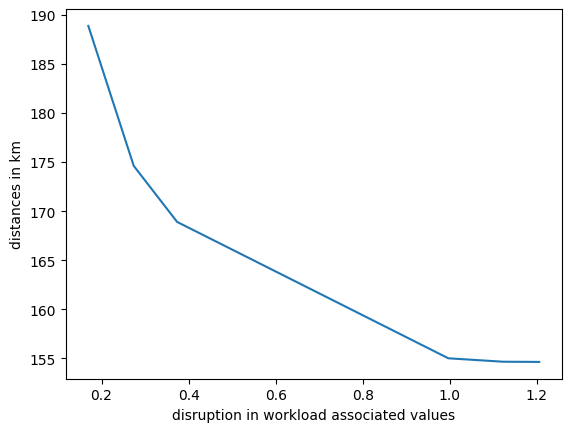

In [12]:
#plot of distances against disruption with increasing values of weight
print(len(dist_list))
dist_list_sorted = [*set(dist_list)]
print(len(dist_list_sorted))
dist_list_w = dist_list
disrupt_list_w = disrupt_list
plt.plot(disrupt_list,dist_list)
plt.xlabel('disruption in workload associated values')
plt.ylabel('distances in km')

In [13]:
# test avec for loop for epsilon constraint and workload values
dist_list=[]
epsilon_list=[]
disrupt_list=[]
epsilon=0
while epsilon<=1.5:
    disrupt=np.sum((wi[j]*(curr_struct[j,i]-V[j,i])**2)/2 for j in range(V.shape[0]) for i in range(V.shape[1]))
    epsilon_constraint = m.addConstr(disrupt <= epsilon)
    obj_distance = np.sum(V[:,0] @ Dij[3,:])+\
                 np.sum(V[:,1] @ Dij[13,:])+\
                 np.sum(V[:,2] @ Dij[15,:])+\
                 np.sum(V[:,3] @ Dij[21,:])
    m.setObjective(obj_distance, GRB.MINIMIZE)
    m.params.outputflag = 0
    m.update()
    m.optimize()
    if m.status == GRB.INF_OR_UNBD:
        m.setParam(GRB.Param.Presolve, 0)
        m.optimize()
    if m.status == GRB.INFEASIBLE:
        #print(m.display(), "\n\tN'A PAS DE SOLUTION!!!")
        pass
    elif m.status == GRB.UNBOUNDED:
        print(m.display(), "\n\tEST NON BORNÉ!!!")
    else:
        dist = np.sum(V.x[:,0] * Dij[3,:])+\
            np.sum(V.x[:,1] * Dij[13,:])+\
            np.sum(V.x[:,2] * Dij[15,:])+\
            np.sum(V.x[:,3] * Dij[21,:])
        #print("with epsilon: ",epsilon," distance is: ",dist)
        disrupt_for_list=np.sum((wi[j]*(curr_struct[j,i]-V.x[j,i])**2)/2 for j in range(V.shape[0]) for i in range(V.shape[1]))
        dist_list.append(dist)
        epsilon_list.append(epsilon)
        disrupt_list.append(disrupt_for_list)
    epsilon +=0.001
    m.remove(epsilon_constraint)
    


/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/1749832232.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  disrupt=np.sum((wi[j]*(curr_struct[j,i]-V[j,i])**2)/2 for j in range(V.shape[0]) for i in range(V.shape[1]))
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/1749832232.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  disrupt_for_list=np.sum((wi[j]*(curr_struct[j,i]-V.x[j,i])**2)/2 for j in range(V.shape[0]) for i in range(V.shape[1]))


1331
[154.64, 154.99, 154.62, 160.71, 160.58, 163.35000000000002, 164.64, 165.9, 166.44, 167.20999999999998, 168.89999999999998, 168.14, 164.57, 172.93, 173.86, 174.62, 183.17, 187.20000000000002, 188.89, 188.13]


Text(0, 0.5, 'distances in km')

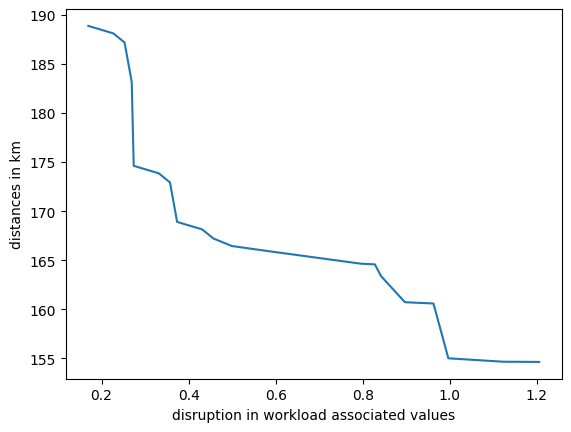

In [14]:
#plot of distances against disruption with increasing values of epsilon
print(len(dist_list))
dist_list_sorted = [*set(dist_list)]
print(dist_list_sorted)
dist_list_e = dist_list
disrupt_list_e = disrupt_list
plt.plot(disrupt_list,dist_list)
plt.xlabel('disruption in workload associated values')
plt.ylabel('distances in km')

<function matplotlib.pyplot.show(close=None, block=None)>

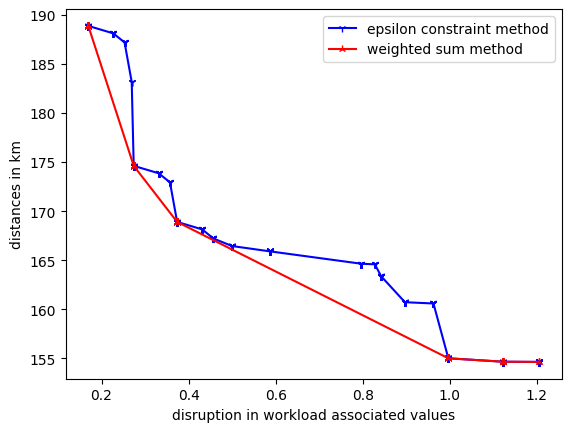

In [15]:
#plot of both epsilon constraint and weighted sum methods for distances against disruption
plt.plot(disrupt_list_e,dist_list_e,color='blue',marker='1')
plt.plot(disrupt_list_w,dist_list_w,color='red',marker='2')
plt.xlabel('disruption in workload associated values')
plt.ylabel('distances in km')
plt.legend(['epsilon constraint method','weighted sum method'])
plt.show


In [16]:
#assignment of multiples SR to the same brick
new_m=Model("assign_SR")

V_continuous = new_m.addMVar(shape=(22,4),name="V",vtype=GRB.CONTINUOUS)
val = new_m.addMVar(shape = (22,4), name = "val", vtype=GRB.BINARY)

for i in range(V_continuous.shape[1]):
    new_m.addConstr(np.sum(np.transpose(Wi) @ V_continuous[:,i]) >= 0.8)
for i in range(V_continuous.shape[1]):
    new_m.addConstr(np.sum(np.transpose(Wi) @ V_continuous[:,i]) <= 1.2)
for i in range(V_continuous.shape[0]):
    new_m.addConstr(quicksum(V_continuous[i])==1)

eps = 0.0001

for i in range(4):
    for j in range(22):
        new_m.addConstr(V_continuous[j,i] >= 0 + eps -(1 - val[j,i]))
        new_m.addConstr(V_continuous[j,i] <= 0 + val[j,i])
        # Model if V > 0, then val = 1, otherwise val = 0


dist_list=[]
weight_list=[]
disrupt_list=[]
weight = np.arange(0,170,0.1)
for weight in weight:
    obj_distance_and_disrupt = np.sum(val[j,0] * Dij[3,j] + weight*((curr_struct[j,0]-V_continuous[j,0])**2)/2 for j in range(V_continuous.shape[0]) )+\
                                np.sum(val[j,1] * Dij[13,j] + weight*((curr_struct[j,1]-V_continuous[j,1])**2)/2 for j in range(V_continuous.shape[0]) )+\
                                np.sum(val[j,2] * Dij[15,j] + weight*((curr_struct[j,2]-V_continuous[j,2])**2)/2 for j in range(V_continuous.shape[0]) )+\
                                np.sum(val[j,3] * Dij[21,j] + weight*((curr_struct[j,3]-V_continuous[j,3])**2)/2 for j in range(V_continuous.shape[0]) )
    new_m.setObjective(obj_distance_and_disrupt, GRB.MINIMIZE)
    new_m.params.outputflag = 0
    new_m.update()
    new_m.optimize()
    if new_m.status == GRB.INF_OR_UNBD:
        new_m.setParam(GRB.Param.Presolve, 0)
        new_m.optimize()
    if new_m.status == GRB.INFEASIBLE:
        print(new_m.display(), "\n\tN'A PAS DE SOLUTION!!!")
    elif new_m.status == GRB.UNBOUNDED:
        print(new_m.display(), "\n\tEST NON BORNÉ!!!")
    else:
        dist =np.sum(val.x[:,0] * Dij[3,:])+\
            np.sum(val.x[:,1] * Dij[13,:])+\
            np.sum(val.x[:,2] * Dij[15,:])+\
            np.sum(val.x[:,3] * Dij[21,:])
        # print("the minimum total distance is: ",dist)
        disrupt_for_list=np.sum((wi[j]*(curr_struct[j,i]-V_continuous.x[j,i])**2)/2 for j in range(V_continuous.shape[0]) for i in range(V_continuous.shape[1]))
        dist_list.append(dist)
        weight_list.append(weight)
        disrupt_list.append(disrupt_for_list)


<(22, 4) matrix variable>


/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/2330718723.py:34: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  obj_distance_and_disrupt = np.sum(val[j,0] * Dij[3,j] + weight*((curr_struct[j,0]-V_continuous[j,0])**2)/2 for j in range(V_continuous.shape[0]) )+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/2330718723.py:35: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(val[j,1] * Dij[13,j] + weight*((curr_struct[j,1]-V_continuous[j,1])**2)/2 for j in range(V_continuous.shape[0]) )+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/2330718723.py:36: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.s

1700
[163.24, 154.64, 175.04000000000002, 189.44, 154.62, 155.41, 157.64999999999998]


Text(0, 0.5, 'distances in km')

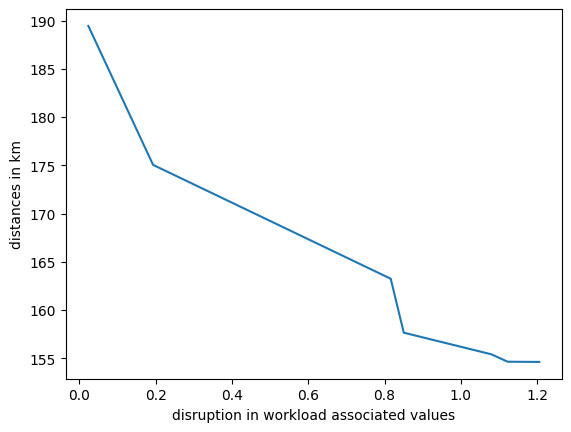

In [17]:
print(len(dist_list))
dist_list_sorted = [*set(dist_list)]
print(dist_list_sorted)
dist_list_w_2 = dist_list
disrupt_list_w_2 = disrupt_list
plt.plot(disrupt_list,dist_list)
plt.xlabel('disruption in workload associated values')
plt.ylabel('distances in km')

1700
[163.24, 154.64, 175.04000000000002, 189.44, 154.62, 155.41, 157.64999999999998]


<function matplotlib.pyplot.show(close=None, block=None)>

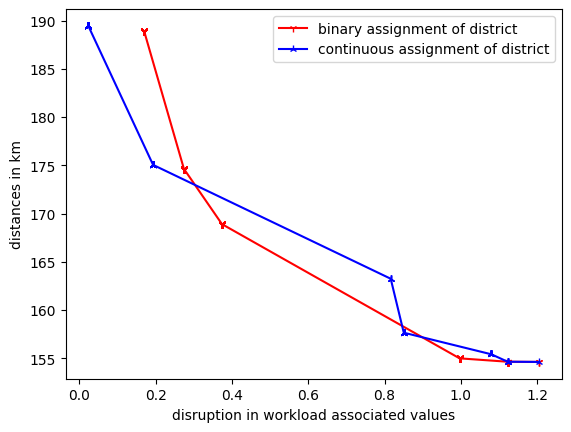

In [18]:
#plot of distance against disruption for binary or continuous assignment matrix.
print(len(dist_list))
dist_list_sorted = [*set(dist_list)]
print(dist_list_sorted)
dist_list_w_2 = dist_list
disrupt_list_w_2 = disrupt_list
plt.plot(disrupt_list_w,dist_list_w,color='red',marker='1')
plt.plot(disrupt_list_w_2,dist_list_w_2,color='blue',marker='2')
plt.xlabel('disruption in workload associated values')
plt.ylabel('distances in km')
plt.legend(['binary assignment of district','continuous assignment of district'])
plt.show

In [19]:
"""
    5.
    Demand increases in all bricks by 20%
       with wehited sum
    it works with a new constraing and vraible 
"""


Wi = np.array(index_val)
Wi *= 1.2

m=Model("assign_SR")

V = m.addMVar(shape = (22,5), name = "V", vtype=GRB.BINARY)
b = m.addMVar(shape = (22), name='b', vtype = GRB.BINARY)

for i in range(V.shape[1]):
    m.addConstr(np.sum(np.transpose(Wi) @ V[:,i]) >= 0.8)
    m.addConstr(np.sum(np.transpose(Wi) @ V[:,i]) <= 1.2)
for i in range(V.shape[0]):
    m.addConstr(quicksum(V[i])==1)

m.addConstr(quicksum(b) == 1)

# multiples sr assigned to each brick
# minmize both distance and disruption with weighted:
weight = 0
obj_distance_and_disrupt = np.sum(V[j,0] * Dij[3,j] + weight*((curr_struct[j,0]-V[j,0])**2)/2 for j in range(V.shape[0]) )+\
                            np.sum(V[j,1] * Dij[13,j] + weight*((curr_struct[j,1]-V[j,1])**2)/2 for j in range(V.shape[0]) )+\
                            np.sum(V[j,2] * Dij[15,j] + weight*((curr_struct[j,2]-V[j,2])**2)/2 for j in range(V.shape[0]) )+\
                            np.sum(V[j,3] * Dij[21,j] + weight*((curr_struct[j,3]-V[j,3])**2)/2 for j in range(V.shape[0]) )+\
                            np.sum(V[j,4] * b[i]* Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))

m.setObjective(obj_distance_and_disrupt, GRB.MINIMIZE)
m.params.outputflag = 0
m.update()
m.optimize()

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    pass
    #print(m.display(), "\n\tN'A PAS DE SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    pass
    #print(m.display(), "\n\tEST NON BORNÉ!!!")
else:
    Vij = pd.DataFrame(data = V.x, index = range(22), columns = ['SR1','SR2','SR3','SR4','SR5'])
    print(Vij)
    print('the new center brick is: ', b.x)

    dist = np.sum(V.x[:,0] @ Dij[3,:])+\
        np.sum(V.x[:,1] @ Dij[13,:])+\
        np.sum(V.x[:,2] @ Dij[15,:])+\
        np.sum(V.x[:,3] @ Dij[21,:])+\
        np.sum(V.x[j,4] * b.x[i]* Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))
    print(dist)
    result_workload = V.x*Wi
    for i in range(4):
        print("the workload of SR", i , " is: ", np.sum(result_workload[:,i]))     




/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/2832936139.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  obj_distance_and_disrupt = np.sum(V[j,0] * Dij[3,j] + weight*((curr_struct[j,0]-V[j,0])**2)/2 for j in range(V.shape[0]) )+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/2832936139.py:29: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(V[j,1] * Dij[13,j] + weight*((curr_struct[j,1]-V[j,1])**2)/2 for j in range(V.shape[0]) )+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/2832936139.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum bui

    SR1  SR2  SR3  SR4  SR5
0  -0.0 -0.0 -0.0  0.0  1.0
1  -0.0 -0.0 -0.0  0.0  1.0
2  -0.0 -0.0 -0.0  1.0  0.0
3   1.0 -0.0 -0.0 -0.0 -0.0
4   1.0 -0.0 -0.0 -0.0  0.0
5   1.0 -0.0 -0.0 -0.0 -0.0
6   1.0 -0.0 -0.0 -0.0  0.0
7   1.0 -0.0 -0.0 -0.0  0.0
8   1.0  0.0 -0.0 -0.0 -0.0
9  -0.0  0.0  1.0  0.0  0.0
10 -0.0 -0.0  1.0 -0.0  0.0
11  0.0 -0.0 -0.0 -0.0  1.0
12 -0.0  1.0 -0.0 -0.0  0.0
13 -0.0  1.0 -0.0  0.0 -0.0
14 -0.0  0.0  0.0  1.0 -0.0
15 -0.0 -0.0  1.0  0.0 -0.0
16 -0.0 -0.0  1.0 -0.0  0.0
17 -0.0  1.0 -0.0 -0.0  0.0
18  0.0 -0.0 -0.0 -0.0  1.0
19 -0.0 -0.0 -0.0 -0.0  1.0
20  0.0 -0.0 -0.0  0.0  1.0
21  0.0 -0.0 -0.0  1.0  0.0
the new center brick is:  [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  1.  0. -0. -0.]
134.04
the workload of SR 0  is:  0.90096
the workload of SR 1  is:  1.1494799999999998
the workload of SR 2  is:  0.94824
the workload of SR 3  is:  0.9206399999999999


/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/2832936139.py:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(V.x[j,4] * b.x[i]* Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))


In [20]:
#assign a new SR if demand increases by 20\% modelled using weighted sum

dist_list=[]
disrupt_list=[]
CB_list=[]
weight_list=[]
Wi = np.array(index_val)
Wi *= 1.2


m=Model("assign_SR")

V = m.addMVar(shape = (22,5), name = "V", vtype=GRB.BINARY)
b = m.addMVar(shape = (22), name='b', vtype = GRB.BINARY)

for i in range(V.shape[1]):
    m.addConstr(np.sum(np.transpose(Wi) @ V[:,i]) >= 0.8)
    m.addConstr(np.sum(np.transpose(Wi) @ V[:,i]) <= 1.2)
for i in range(V.shape[0]):
    m.addConstr(quicksum(V[i])==1)

m.addConstr(quicksum(b) == 1)

# multiples sr assigned to each brick
# minmize both distance and disruption with weighted:
weight = np.arange(0,170,1)
for weight in weight:
    obj_distance_and_disrupt = np.sum(V[j,0] * Dij[3,j] + weight*((curr_struct[j,0]-V[j,0])**2)/2 for j in range(V.shape[0]) )+\
                                np.sum(V[j,1] * Dij[13,j] + weight*((curr_struct[j,1]-V[j,1])**2)/2 for j in range(V.shape[0]) )+\
                                np.sum(V[j,2] * Dij[15,j] + weight*((curr_struct[j,2]-V[j,2])**2)/2 for j in range(V.shape[0]) )+\
                                np.sum(V[j,3] * Dij[21,j] + weight*((curr_struct[j,3]-V[j,3])**2)/2 for j in range(V.shape[0]) )+\
                                np.sum(V[j,4] * b[i]* Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))

    m.setObjective(obj_distance_and_disrupt, GRB.MINIMIZE)
    m.params.outputflag = 0
    m.update()
    m.optimize()

    if m.status == GRB.INF_OR_UNBD:
        m.setParam(GRB.Param.Presolve, 0)
        m.optimize()

    if m.status == GRB.INFEASIBLE:
        pass
        #print(m.display(), "\n\tN'A PAS DE SOLUTION!!!")
    elif m.status == GRB.UNBOUNDED:
        pass
        #print(m.display(), "\n\tEST NON BORNÉ!!!")
    else:
        # Vij = pd.DataFrame(data = V.x, index = range(22), columns = ['SR1','SR2','SR3','SR4','SR5'])
        # print(Vij)
        # print('the new center brick is: ', b.x)

        dist = np.sum(V.x[:,0] @ Dij[3,:])+\
            np.sum(V.x[:,1] @ Dij[13,:])+\
            np.sum(V.x[:,2] @ Dij[15,:])+\
            np.sum(V.x[:,3] @ Dij[21,:])+\
            np.sum(V.x[j,4] * b.x[i]* Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))
        
        disrupt=np.sum(((curr_struct[j,i]-V.x[j,i])**2)/2 for j in range(V.shape[0]) for i in range(V.shape[1]-1))
        dist_list.append(dist)
        disrupt_list.append(disrupt)
        for i in range(len(b.x)):
            if b.x[i]==1:
                CB_list.append(i)
        weight_list.append(weight)



/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/3144987577.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  obj_distance_and_disrupt = np.sum(V[j,0] * Dij[3,j] + weight*((curr_struct[j,0]-V[j,0])**2)/2 for j in range(V.shape[0]) )+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/3144987577.py:29: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(V[j,1] * Dij[13,j] + weight*((curr_struct[j,1]-V[j,1])**2)/2 for j in range(V.shape[0]) )+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/3144987577.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum bui

<function matplotlib.pyplot.show(close=None, block=None)>

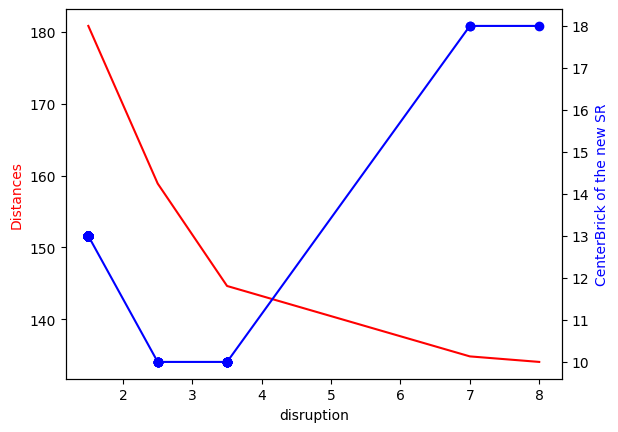

In [21]:
#plot of disruption and center brick in function of disruption
dist_list_sorted = [*set(dist_list)]
CB_list_sorted = [*set(CB_list)]
disrupt_list_sorted = [*set(disrupt_list)]
fig,ax = plt.subplots()
ax.plot(disrupt_list,dist_list,color="red")
ax.set_xlabel("disruption")
ax.set_ylabel("Distances", color="red")
ax2=ax.twinx()
ax2.plot(disrupt_list,CB_list,color="blue", marker='o')
ax2.set_ylabel("CenterBrick of the new SR",color="blue")
plt.show

In [22]:
#assign a new SR if demand increases by 20\% modelled using epsilon constraint

Wi = np.array(index_val)
Wi *= 1.2

m=Model("assign_SR")

V = m.addMVar(shape = (22,5), name = "V", vtype=GRB.BINARY)
b = m.addMVar(shape = (22), name='b', vtype = GRB.BINARY)

for i in range(V.shape[1]):
    m.addConstr(np.sum(np.transpose(Wi) @ V[:,i]) >= 0.8)
    m.addConstr(np.sum(np.transpose(Wi) @ V[:,i]) <= 1.2)
for i in range(V.shape[0]):
    m.addConstr(quicksum(V[i])==1)

m.addConstr(quicksum(b) == 1)

# multiples sr assigned to each brick
# minmize both distance and disruption with weighted:

dist_list=[]
epsilon_list=[]
disrupt_list=[]
CB_list=[]
epsilon=0
while epsilon<=10:
    disrupt=np.sum(((curr_struct[j,i]-V[j,i])**2)/2 for j in range(V.shape[0]) for i in range(V.shape[1]-1))
    epsilon_constraint = m.addConstr(disrupt <= epsilon)
    obj_distance_and_disrupt = np.sum(V[j,0] * Dij[3,j] for j in range(V.shape[0]) )+\
                                np.sum(V[j,1] * Dij[13,j] for j in range(V.shape[0]) )+\
                                np.sum(V[j,2] * Dij[15,j]  for j in range(V.shape[0]) )+\
                                np.sum(V[j,3] * Dij[21,j]  for j in range(V.shape[0]) )+\
                                np.sum(V[j,4] * b[i]* Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))

    m.setObjective(obj_distance_and_disrupt, GRB.MINIMIZE)
    m.params.outputflag = 0
    m.update()
    m.optimize()

    if m.status == GRB.INF_OR_UNBD:
        m.setParam(GRB.Param.Presolve, 0)
        m.optimize()

    if m.status == GRB.INFEASIBLE:
        pass
        #print(m.display(), "\n\tN'A PAS DE SOLUTION!!!")
    elif m.status == GRB.UNBOUNDED:
        pass
        #print(m.display(), "\n\tEST NON BORNÉ!!!")
    else:
        # Vij = pd.DataFrame(data = V.x, index = range(22), columns = ['SR1','SR2','SR3','SR4','SR5'])
        # print(Vij)
        # print('the new center brick is: ', b.x)

        dist = np.sum(V.x[:,0] @ Dij[3,:])+\
            np.sum(V.x[:,1] @ Dij[13,:])+\
            np.sum(V.x[:,2] @ Dij[15,:])+\
            np.sum(V.x[:,3] @ Dij[21,:])+\
            np.sum(V.x[j,4] * b.x[i]* Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))
        #print("with epsilon: ",epsilon," distance is: ",dist)
        disrupt=np.sum(((curr_struct[j,i]-V.x[j,i])**2)/2 for j in range(V.shape[0]) for i in range(V.shape[1]-1))
        dist_list.append(dist)
        epsilon_list.append(epsilon)
        disrupt_list.append(disrupt)
        for i in range(len(b.x)):
            if b.x[i]==1:
                CB_list.append(i)
    epsilon +=0.05
    m.remove(epsilon_constraint)


/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/3873131687.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  disrupt=np.sum(((curr_struct[j,i]-V[j,i])**2)/2 for j in range(V.shape[0]) for i in range(V.shape[1]-1))
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/3873131687.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  obj_distance_and_disrupt = np.sum(V[j,0] * Dij[3,j] for j in range(V.shape[0]) )+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/3873131687.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(V[j,1] * Dij[

<function matplotlib.pyplot.show(close=None, block=None)>

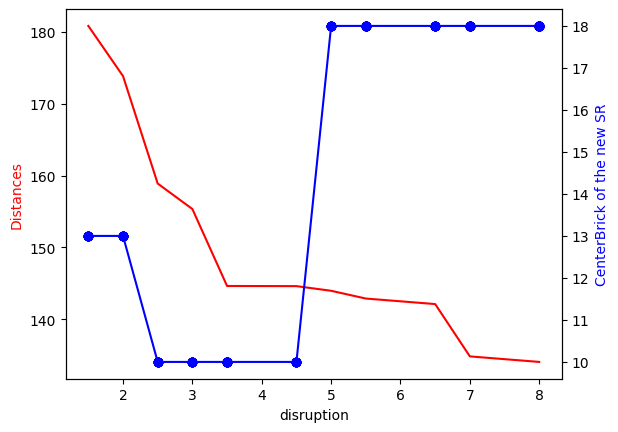

In [23]:
#plot of disruption and center brick in function of disruption
dist_list_sorted = [*set(dist_list)]
CB_list_sorted = [*set(CB_list)]
disrupt_list_sorted = [*set(disrupt_list)]
fig,ax = plt.subplots()
ax.plot(disrupt_list,dist_list,color="red")
ax.set_xlabel("disruption")
ax.set_ylabel("Distances", color="red")
ax2=ax.twinx()
ax2.plot(disrupt_list,CB_list,color="blue", marker='o')
ax2.set_ylabel("CenterBrick of the new SR",color="blue")
plt.show


In [24]:
#re assign every SR to a new district

from tqdm import tqdm

Wi = np.array(index_val)

arr_dist = []

m=Model("assign_SR")

V = m.addMVar(shape = (22,4), name = "V", vtype=GRB.BINARY)

for i in range(V.shape[1]):
    m.addConstr(np.sum(np.transpose(Wi) @ V[:,i]) >= 0.8)
for i in range(V.shape[1]):
    m.addConstr(np.sum(np.transpose(Wi) @ V[:,i]) <= 1.2)
for i in range(V.shape[0]):
    m.addConstr(quicksum(V[i])==1)

O = m.addMVar(shape=(22,4), name  = "O", vtype = GRB.BINARY)
for i in range(O.shape[0]):
    m.addConstr(quicksum(O[i]) <= 1)

for i in range(O.shape[1]):
    m.addConstr(quicksum(O[:,i]) == 1)

# multiples sr assigned to each brick
obj_distance =  np.sum(V[j,0] * O[i,0] * Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))+\
                np.sum(V[j,1] * O[i,1] * Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))+\
                np.sum(V[j,2] * O[i,2] * Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))+\
                np.sum(V[j,3] * O[i,3] * Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))

m.setObjective(obj_distance, GRB.MINIMIZE)

m.params.outputflag = 0
m.update()
m.optimize()

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    pass
    #print(m.display(), "\n\tN'A PAS DE SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    pass
#print(m.display(), "\n\tEST NON BORNÉ!!!")
else:
    #print("FEASABLE")
    Vij = pd.DataFrame(data = V.x, index = range(22), columns = ['SR1','SR2','SR3','SR4'])
    Oij = pd.DataFrame(data = O.x, index = range(22), columns = ['SR1','SR2','SR3','SR4'])

    dist = np.sum(V.x[j,0] * O.x[i,0] * Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))+\
           np.sum(V.x[j,1] * O.x[i,1] * Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))+\
           np.sum(V.x[j,2] * O.x[i,2] * Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))+\
           np.sum(V.x[j,3] * O.x[i,3] * Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))
    print('The Vij matrix is:')
    print(Vij)
    print('the minimum distance is: ',dist)
    print('The center brick matrix is:')
    print(Oij)

/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/116623387.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  obj_distance =  np.sum(V[j,0] * O[i,0] * Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/116623387.py:29: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(V[j,1] * O[i,1] * Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/116623387.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(V[j,2]

The Vij matrix is:
    SR1  SR2  SR3  SR4
0   0.0  0.0  1.0  0.0
1   0.0  0.0  1.0  0.0
2   0.0  0.0  1.0  0.0
3   0.0  1.0  0.0  0.0
4   0.0  1.0  0.0  0.0
5   0.0  1.0  0.0  0.0
6   0.0  1.0  0.0  0.0
7   0.0  1.0  0.0  0.0
8   0.0  1.0  0.0  0.0
9   1.0  0.0  0.0  0.0
10  1.0  0.0  0.0  0.0
11  0.0  1.0  0.0  0.0
12  0.0  0.0  0.0  1.0
13  0.0  0.0  0.0  1.0
14  1.0  0.0  0.0  0.0
15  1.0  0.0  0.0  0.0
16  0.0  0.0  0.0  1.0
17  0.0  0.0  0.0  1.0
18  0.0  0.0  1.0  0.0
19  0.0  0.0  1.0  0.0
20  0.0  0.0  1.0  0.0
21  0.0  0.0  1.0  0.0
the minimum distance is:  103.57
The center brick matrix is:
    SR1  SR2  SR3  SR4
0   0.0  0.0  0.0  0.0
1   0.0  0.0  1.0  0.0
2   0.0  0.0  0.0  0.0
3   0.0  0.0  0.0  0.0
4   0.0  0.0  0.0  0.0
5   0.0  1.0  0.0  0.0
6   0.0  0.0  0.0  0.0
7   0.0  0.0  0.0  0.0
8   0.0  0.0  0.0  0.0
9   0.0  0.0  0.0  0.0
10  0.0  0.0  0.0  0.0
11  0.0  0.0  0.0  0.0
12  0.0  0.0  0.0  0.0
13  0.0  0.0  0.0  0.0
14  1.0  0.0  0.0  0.0
15  0.0  0.0  0.0  0.0


/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/116623387.py:54: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  dist = np.sum(V.x[j,0] * O.x[i,0] * Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/116623387.py:55: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(V.x[j,1] * O.x[i,1] * Dij[i,j] for j in range(V.shape[0]) for i in range(V.shape[0]))+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/116623387.py:56: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(V.x[j,2

In [25]:
#assign in function of preferences
dist_list=[]
weight_list=[]
weight = np.arange(0,-4,-0.01)
pref = pref1  # can be chosen between pref1, pref2, and pref3
for weight in weight:
    obj_distance_and_disrupt = np.sum(V[j,0] * Dij[3,j] + weight*V[j,0]*pref[j,0] for j in range(V.shape[0]) )+\
                            np.sum(V[j,1] * Dij[13,j] + weight*V[j,0]*pref[j,1] for j in range(V.shape[0]) )+\
                            np.sum(V[j,2] * Dij[15,j] + weight*V[j,0]*pref[j,2] for j in range(V.shape[0]) )+\
                            np.sum(V[j,3] * Dij[21,j] + weight*V[j,0]*pref[j,3] for j in range(V.shape[0]) )
    m.setObjective(obj_distance_and_disrupt, GRB.MINIMIZE)
    m.params.outputflag = 0
    m.update()
    m.optimize()
    if m.status == GRB.INF_OR_UNBD:
        m.setParam(GRB.Param.Presolve, 0)
        m.optimize()
    if m.status == GRB.INFEASIBLE:
        print(m.display(), "\n\tN'A PAS DE SOLUTION!!!")
    elif m.status == GRB.UNBOUNDED:
        print(m.display(), "\n\tEST NON BORNÉ!!!")
    else:
        dist = np.sum(V.x[:,0] * Dij[3,:])+\
            np.sum(V.x[:,1] * Dij[13,:])+\
            np.sum(V.x[:,2] * Dij[15,:])+\
            np.sum(V.x[:,3] * Dij[21,:])
        dist_list.append(dist)
        weight_list.append(-weight)


/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/644831734.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  obj_distance_and_disrupt = np.sum(V[j,0] * Dij[3,j] + weight*V[j,0]*pref[j,0] for j in range(V.shape[0]) )+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/644831734.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(V[j,1] * Dij[13,j] + weight*V[j,0]*pref[j,1] for j in range(V.shape[0]) )+\
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_27549/644831734.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(V[j,2] * Dij[15

In [26]:
print(len(weight_list))
weight_list1 = weight_list
dist_list1 = dist_list

400


In [27]:
print(len(weight_list))
weight_list2 = weight_list
dist_list2 = dist_list

400


In [28]:
print(len(weight_list))
weight_list3 = weight_list
dist_list3 = dist_list


400


400
[166.54, 208.63, 244.79000000000002, 184.45, 154.62, 159.76]


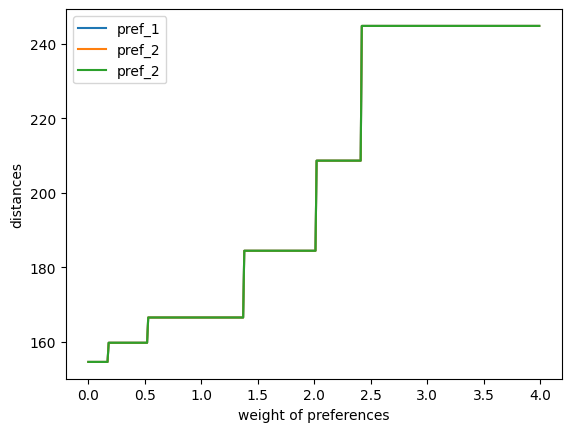

In [29]:
#plot of the distance against the importance of the preference.
print(len(dist_list))
dist_list_sorted = [*set(dist_list)]
print(dist_list_sorted)
plt.plot(weight_list1,dist_list1)
plt.plot(weight_list2,dist_list2)
plt.plot(weight_list3,dist_list3)
plt.xlabel('weight of preferences')
plt.ylabel('distances')
plt.legend(['pref_1','pref_2','pref_2'])